In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sqlparse
import libinjection
import math
from collections import Counter
from sklearn.model_selection import train_test_split
import sklearn.model_selection
import sklearn.feature_extraction
import sklearn.ensemble
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter('ignore')

D:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# 设置图表全局参数
plt.rcParams['font.size'] = 18.0
plt.rcParams['figure.figsize'] = 12.0,5.0

In [3]:
def plot_it(df,label_x,label_y):
    fig, ax = plt.subplots(subplot_kw={'facecolor':'#EEEEE5'})
    ax.grid(color='grey', linestyle='solid')
    df.T.plot(kind='bar', logx=False, rot=0, ax=ax, colormap='PiYG')
    ax.legend(loc=0, prop={'size':14})
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    return ax

In [4]:
# 读入训练数据集
basedir = 'data'
filelist = os.listdir(basedir)
df_list = []
for file in filelist:
    #将csv文件数据读入DataFrame中
    df = pd.read_csv(os.path.join(basedir, file), sep='\r\n', names=['raw_sql'], header=None,engine = 'python')
    #数据对应的legit/malicious标签是数据集已经定义好的，直接使用完成数据标记
    df['type'] = 'legit' if file.split('.')[0] == 'legit' else 'malicious'
    df_list.append(df)
    
# 对数据进行处理

# ignore_index = true标识将文件合并后的pandas对象list采用0，...，n-1下标，忽略原下标
dataframe = pd.concat(df_list, ignore_index=True)

 # 缺失值处理，inplace = True表示就地删除包含None值的行，默认axis=0表示行检查和处理，axis=1表示列检查和处理
dataframe.dropna(inplace=True)

#数据去重
dataframe.drop_duplicates()
dataframe['type'].value_counts()

malicious    13014
legit         1850
Name: type, dtype: int64

In [5]:
# 数据混洗
dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
# dataframe.head()默认返回前五行数据
dataframe.head()

,raw_sql,type
4884,'; exec master..xp_cmdshell 'ping 10.10.1.2'--,malicious
7965,create user name identified by 'pass123',malicious
3584,create user name identified by pass123 tempora...,malicious
5466,"exec sp_addlogin 'name' , 'password'",malicious
2371,"exec sp_addsrvrolemember 'name' , 'sysadmin'",malicious


In [6]:
#SQL注入检测算法
#实验尝试将SQLParse替换成libinjection,但是效果不明显，之后会将两种方法得到的结果进行对比

#SQLParse方法,实现的是将SQL语句每一个/每一类分词打上标签
#https://docs.python.org/3/reference/expressions.html#displays-for-lists-sets-and-dictionaries
import sqlparse
def parse_it(raw_sql):
    parsed = sqlparse.parse(raw_sql)
    return [token._get_repr_name() for parse in parsed for token in parse.tokens if token._get_repr_name() != 'Whitespace']
#将数据集中的每一条语句都进行SQLParse处理
dataframe['parsed_sql'] = dataframe['raw_sql'].map(lambda x:parse_it(x))

#libinjection方法，最终效果也是像SQLParse一样，将字符串类型通过词法和语法分析，转换成[枚举]类型
#https://github.com/client9/libinjection/blob/e86ff4019a4343579cc307d96d79272d5efcd1be/src/libinjection_sqli.c
#https://github.com/client9/libinjection/wiki/doc-sqli-python
#https://www.slideshare.net/nickgsuperstar/libinjection-blackhatusa2012
def parse_with_libinjection(raw_sql):
    parsed = libinjection.is_sql_injection(raw_sql)
    return parsed['fingerprint']
dataframe['lib_parsed_sql'] = dataframe['raw_sql'].map(lambda x:parse_with_libinjection(x))

In [7]:
dataframe.head()

,raw_sql,type,parsed_sql,lib_parsed_sql
4884,'; exec master..xp_cmdshell 'ping 10.10.1.2'--,malicious,"[Single, Identifier, Float, Float, Float, Erro...",s;Tns
7965,create user name identified by 'pass123',malicious,"[DDL, Keyword, Identifier, Keyword, Keyword, S...",sns
3584,create user name identified by pass123 tempora...,malicious,"[DDL, Keyword, Identifier, Keyword, Keyword, I...",Ennnn
5466,"exec sp_addlogin 'name' , 'password'",malicious,"[Keyword, Identifier, IdentifierList]",snsns
2371,"exec sp_addsrvrolemember 'name' , 'sysadmin'",malicious,"[Keyword, Identifier, IdentifierList]",snsns


In [8]:
#ngrams实现的效果是将token进行拆分和组合,n为组合最大长度
def ngrams(lst,N):
    ngrams = []
    for n in range(N):
        ngrams += zip(*(lst[i:] for i in range(n+1)))
    return [str(tuple) for tuple in ngrams]

In [9]:
dataframe['sequences'] = dataframe['parsed_sql'].map(lambda x: ngrams(x, 3))
dataframe['lib_sequences'] = dataframe['lib_parsed_sql'].map(lambda x:ngrams(x,3))

In [10]:
# 将一条数据的legit/malicous属性映射到这条数据的token组合集
def token_expansion(series, types):
    _tokens, _types = zip(*[(token,token_type) for t_list,token_type in zip(series,types) for token in t_list])
    return pd.Series(_tokens), pd.Series(_types)

In [11]:
# G-tests 似然率，最大似然显著统计检测
# http://www.biostathandbook.com/gtestgof.html
# 这里使用G-test检测token集和sqli及sql之间的相关性
import data_hacking.simple_stats as ss
g_test = ss.GTest()

tokens, types = token_expansion(dataframe['sequences'], dataframe['type'])
tokens_lib,types_lib = token_expansion(dataframe['lib_sequences'],dataframe['type'])
df_ct, df_cd, df_stats = g_test.highest_gtest_scores(tokens, types, matches=0, N=0)
df_ct_lib,df_cd_lib,df_stats_lib = g_test.highest_gtest_scores(tokens_lib, types_lib, matches=0, N=0)

In [12]:
df_stats_lib.sort_values('malicious_g', ascending=0).head()

,legit,malicious,legit_cd,malicious_cd,total_cd,legit_exp,legit_g,malicious_exp,malicious_g
"('E', 'v')",1.0,9640.0,0.000104,0.999896,9641.0,1158.376168,-14.109549,8482.623832,2465.936920
"('U', 'E')",0.0,9629.0,0.000000,1.000000,9629.0,1156.934356,0.000000,8472.065644,2465.120706
"('U', 'E', 'v')",0.0,9621.0,0.000000,1.000000,9621.0,1155.973147,0.000000,8465.026853,2463.072626
"('U',)",18.0,9635.0,0.001865,0.998135,9653.0,1159.817981,-149.963278,8493.182019,2430.690352
"('v',)",25.0,9665.0,0.002580,0.997420,9690.0,1164.263569,-192.048411,8525.736431,2424.401623


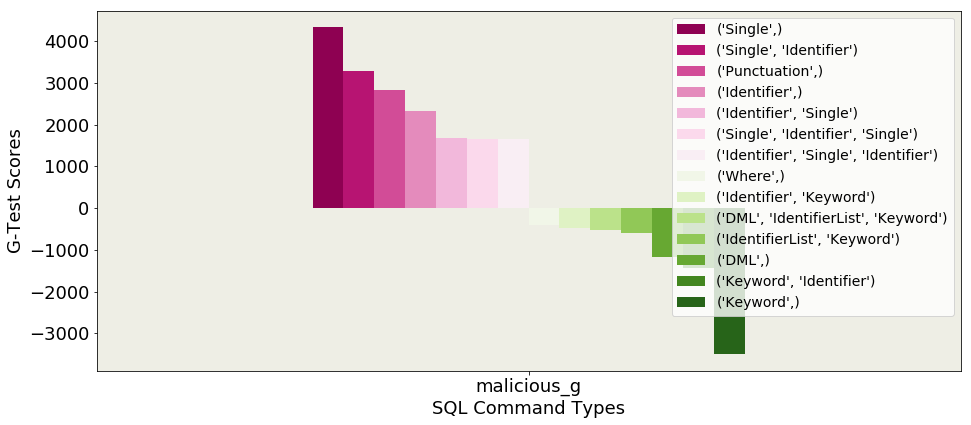

In [13]:
# Now plot the the head() and the tail() of the dataframe to see who's been naughty or nice
sorted_df = df_stats.sort_values('malicious_g', ascending=0)
naughty = sorted_df.head(7)
nice = sorted_df.tail(7).sort_values('malicious_g', ascending=0)
naughty_and_nice = pd.concat([naughty, nice])
ax = plot_it(naughty_and_nice[['malicious_g']],'SQL Command Types','G-Test Scores')

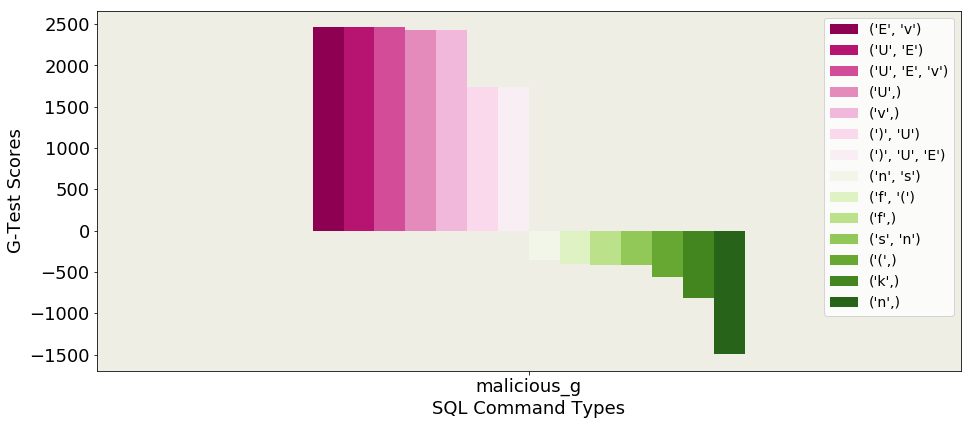

In [14]:
sorted_df_lib = df_stats_lib.sort_values('malicious_g', ascending=0)
naughty_lib = sorted_df_lib.head(7)
nice_lib = sorted_df_lib.tail(7).sort_values('malicious_g', ascending=0)
naughty_and_nice_lib = pd.concat([naughty_lib, nice_lib])
ax = plot_it(naughty_and_nice_lib[['malicious_g']],'SQL Command Types','G-Test Scores')

In [15]:
dataframe[dataframe['sequences'].map(lambda x: "('Punctuation',)" in x)].head()

,raw_sql,type,parsed_sql,lib_parsed_sql,sequences,lib_sequences
3584,create user name identified by pass123 tempora...,malicious,"[DDL, Keyword, Identifier, Keyword, Keyword, I...",Ennnn,"[('DDL',), ('Keyword',), ('Identifier',), ('Ke...","[('E',), ('n',), ('n',), ('n',), ('n',), ('E',..."
8381,grant connect to name; grant resource to name;,malicious,"[Keyword, Keyword, Keyword, Identifier, Punctu...",knnn;,"[('Keyword',), ('Keyword',), ('Keyword',), ('I...","[('k',), ('n',), ('n',), ('n',), (';',), ('k',..."
5822,"insert into users(login, password, level) valu...",malicious,"[DML, Keyword, Function, Keyword, Punctuation,...",Tn(n),"[('DML',), ('Keyword',), ('Function',), ('Keyw...","[('T',), ('n',), ('(',), ('n',), (')',), ('T',..."
13475,"CREATE FUNCTION sylph.add_article(char, char, ...",legit,"[DDL, Keyword, Identifier, Keyword, Identifier...",Ekn(f,"[('DDL',), ('Keyword',), ('Identifier',), ('Ke...","[('E',), ('k',), ('n',), ('(',), ('f',), ('E',..."
978,"CREATE FUNCTION sylph.add_comment(integer, cha...",legit,"[DDL, Keyword, Identifier, Keyword, Identifier...",sEn(s,"[('DDL',), ('Keyword',), ('Identifier',), ('Ke...","[('s',), ('E',), ('n',), ('(',), ('s',), ('s',..."


In [16]:
# 进行熵计算
def entropy(s):
    p,lns = Counter(s),float(len(s))
    return -sum(count/lns * math.log(count/lns, 2) for count in p.values())

In [17]:
dataframe['length'] = dataframe['parsed_sql'].map(lambda x: len(x))
dataframe['entropy'] = dataframe['raw_sql'].map(lambda x: entropy(x))
dataframe.head()

,raw_sql,type,parsed_sql,lib_parsed_sql,sequences,lib_sequences,length,entropy
4884,'; exec master..xp_cmdshell 'ping 10.10.1.2'--,malicious,"[Single, Identifier, Float, Float, Float, Erro...",s;Tns,"[('Single',), ('Identifier',), ('Float',), ('F...","[('s',), (';',), ('T',), ('n',), ('s',), ('s',...",7,4.368792
7965,create user name identified by 'pass123',malicious,"[DDL, Keyword, Identifier, Keyword, Keyword, S...",sns,"[('DDL',), ('Keyword',), ('Identifier',), ('Ke...","[('s',), ('n',), ('s',), ('s', 'n'), ('n', 's'...",6,4.037326
3584,create user name identified by pass123 tempora...,malicious,"[DDL, Keyword, Identifier, Keyword, Keyword, I...",Ennnn,"[('DDL',), ('Keyword',), ('Identifier',), ('Ke...","[('E',), ('n',), ('n',), ('n',), ('n',), ('E',...",13,4.028603
5466,"exec sp_addlogin 'name' , 'password'",malicious,"[Keyword, Identifier, IdentifierList]",snsns,"[('Keyword',), ('Identifier',), ('IdentifierLi...","[('s',), ('n',), ('s',), ('n',), ('s',), ('s',...",3,4.030493
2371,"exec sp_addsrvrolemember 'name' , 'sysadmin'",malicious,"[Keyword, Identifier, IdentifierList]",snsns,"[('Keyword',), ('Identifier',), ('IdentifierLi...","[('s',), ('n',), ('s',), ('n',), ('s',), ('s',...",3,4.010013


In [18]:
# For each SQL statement aggregate the malicious and legit g-test scores as features
#计算legit_g,malicious_g
def g_aggregate(sequence, name,df_stats):
    try:
        g_scores = [df_stats.ix[item][name] for item in sequence]
    except KeyError:
        return 0
    return sum(g_scores) / len(g_scores) if g_scores else 0  # Average
dataframe['malicious_g'] = dataframe['sequences'].map(lambda x: g_aggregate(x, 'malicious_g',df_stats))
dataframe['legit_g'] = dataframe['sequences'].map(lambda x: g_aggregate(x, 'legit_g',df_stats))
dataframe['malicious_g_lib'] = dataframe['lib_sequences'].map(lambda x: g_aggregate(x, 'malicious_g',df_stats_lib))
dataframe['legit_g_lib'] = dataframe['lib_sequences'].map(lambda x: g_aggregate(x, 'legit_g',df_stats_lib))
dataframe.head()

,raw_sql,type,parsed_sql,lib_parsed_sql,sequences,lib_sequences,length,entropy,malicious_g,legit_g,malicious_g_lib,legit_g_lib
4884,'; exec master..xp_cmdshell 'ping 10.10.1.2'--,malicious,"[Single, Identifier, Float, Float, Float, Erro...",s;Tns,"[('Single',), ('Identifier',), ('Float',), ('F...","[('s',), (';',), ('T',), ('n',), ('s',), ('s',...",7,4.368792,837.586132,-114.368620,86.559848,1001.125724
7965,create user name identified by 'pass123',malicious,"[DDL, Keyword, Identifier, Keyword, Keyword, S...",sns,"[('DDL',), ('Keyword',), ('Identifier',), ('Ke...","[('s',), ('n',), ('s',), ('s', 'n'), ('n', 's'...",6,4.037326,-476.392403,2110.823887,-17.301153,2354.943386
3584,create user name identified by pass123 tempora...,malicious,"[DDL, Keyword, Identifier, Keyword, Keyword, I...",Ennnn,"[('DDL',), ('Keyword',), ('Identifier',), ('Ke...","[('E',), ('n',), ('n',), ('n',), ('n',), ('E',...",13,4.028603,-744.397024,2384.237447,-522.476096,4871.139966
5466,"exec sp_addlogin 'name' , 'password'",malicious,"[Keyword, Identifier, IdentifierList]",snsns,"[('Keyword',), ('Identifier',), ('IdentifierLi...","[('s',), ('n',), ('s',), ('n',), ('s',), ('s',...",3,4.030493,-444.382033,1771.005700,-133.896327,2469.202380
2371,"exec sp_addsrvrolemember 'name' , 'sysadmin'",malicious,"[Keyword, Identifier, IdentifierList]",snsns,"[('Keyword',), ('Identifier',), ('IdentifierLi...","[('s',), ('n',), ('s',), ('n',), ('s',), ('s',...",3,4.010013,-444.382033,1771.005700,-133.896327,2469.202380


Text(0,0.5,'SQL Statement Entropy')

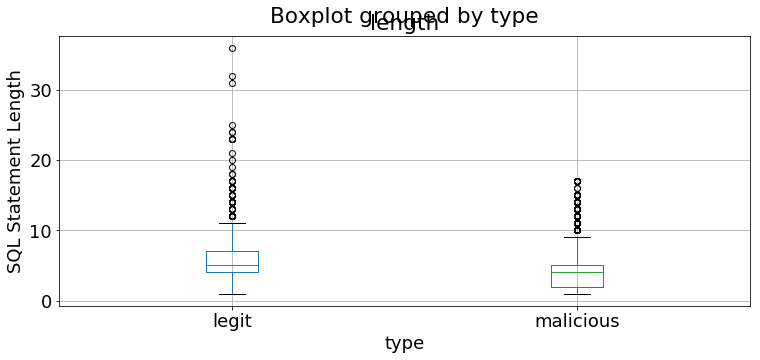

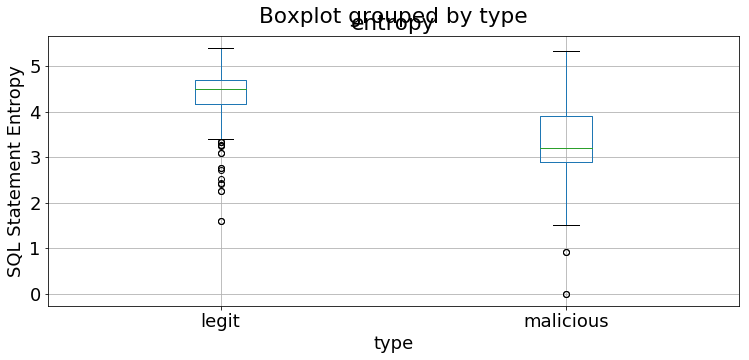

In [19]:
# Boxplots show you the distribution of the data (spread).
# http://en.wikipedia.org/wiki/Box_plot

# Plot the length and entropy of SQL statements
# Fixme Brian: make these pretty
# 不是很理解这这里的图表达的意思
dataframe.boxplot('length','type')
plt.ylabel('SQL Statement Length')
dataframe.boxplot('entropy','type')
plt.ylabel('SQL Statement Entropy')

Text(0,0.5,'SQL Statement Entropy')

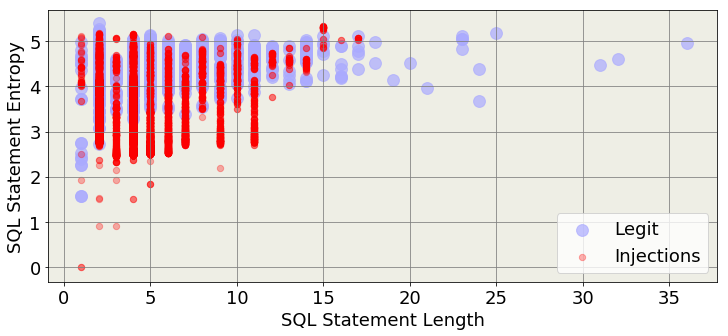

In [20]:
# 将熵和长度可视化
# Split the classes up so we can set colors, size, labels
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
cond = dataframe['type'] == 'malicious'
evil = dataframe[cond]
legit = dataframe[~cond]
plt.scatter(legit['length'], legit['entropy'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(evil['length'], evil['entropy'], s=40, c='r', label='Injections', alpha=.3)
plt.legend()
plt.xlabel('SQL Statement Length')
plt.ylabel('SQL Statement Entropy')

Text(0.5,0,'Malicious SQL G-Test Score')

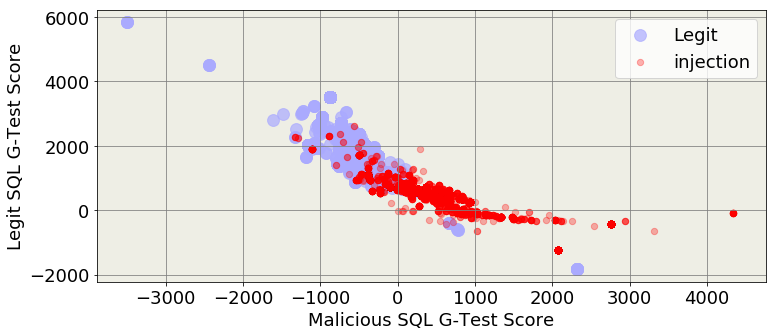

In [21]:
#legit_g和malicious_g可视化
# Split the classes up so we can set colors, size, labels
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
plt.scatter(legit['malicious_g'], legit['legit_g'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(evil['malicious_g'], evil['legit_g'], s=40, c='r', label='injection', alpha=.3)
plt.legend()
plt.ylabel('Legit SQL G-Test Score')
plt.xlabel('Malicious SQL G-Test Score')

Text(0.5,0,'Malicious SQL G-Test Score')

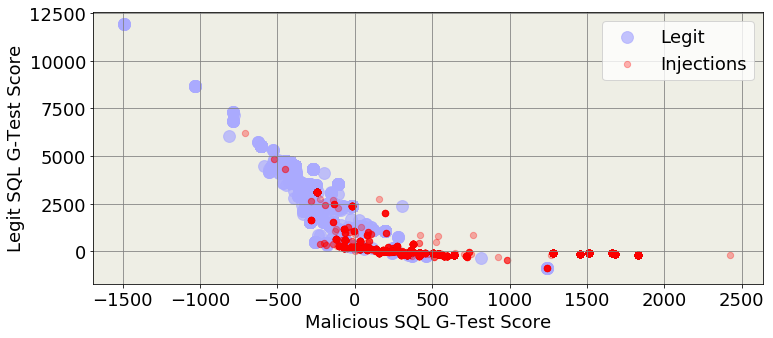

In [22]:
#legit_g和malicious_g可视化
# Split the classes up so we can set colors, size, labels
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
plt.scatter(legit['malicious_g_lib'], legit['legit_g_lib'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(evil['malicious_g_lib'], evil['legit_g_lib'], s=40, c='r', label='Injections', alpha=.3)
plt.legend()
plt.ylabel('Legit SQL G-Test Score')
plt.xlabel('Malicious SQL G-Test Score')

In [23]:
# 生成特征向量列表
X = dataframe.as_matrix(['length', 'entropy','legit_g','malicious_g'])
X_lib = dataframe.as_matrix(['length', 'entropy','legit_g_lib','malicious_g_lib'])
# 生成scikit learn需要使用的label
y = np.array(dataframe['type'].tolist())

In [24]:
#使用随机森林算法进行训练
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
# Now we can use scikit learn's cross validation to assess predictive performance.
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=10, n_jobs=-1)
scores.mean()

0.98493308086865

In [25]:
clf_lib = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
scores = sklearn.model_selection.cross_val_score(clf_lib, X_lib, y, cv=10, n_jobs=-1)
scores.mean()

0.9843951754143809

In [26]:
# Train on a 80/20 split,划分训练集和样本集
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, dataframe.index, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [27]:
# Train on a 80/20 split
X_train_lib, X_test_lib, y_train_lib, y_test_lib, index_train_lib, index_test_lib = train_test_split(X_lib, y, dataframe.index, test_size=0.2)
clf_lib.fit(X_train_lib, y_train_lib)
y_pred_lib = clf_lib.predict(X_test_lib)

In [28]:
# 绘制混沌矩阵
def plot_cm(cm, labels,k,f):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    s = 'C:/Users/beiji/Desktop/data_hacking-master/sql_injection/ret_image/'
    for i in range(len(labels)):
        s = s+k
        s = s + '-'
        s = s+labels[i]
    plt.savefig(s)
    plt.show()
 

In [29]:
labels = ['legit','malicious']

Confusion Matrix Stats
legit/legit: 98.38% (365/371)
legit/malicious: 1.62% (6/371)
malicious/legit: 0.08% (2/2602)
malicious/malicious: 99.92% (2600/2602)


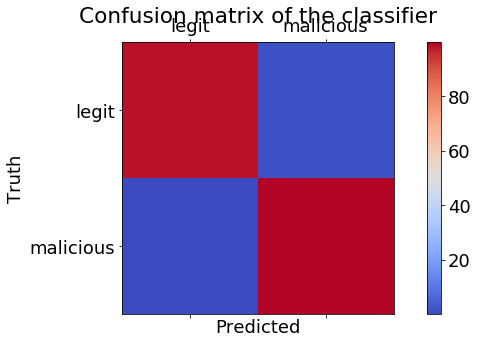

In [30]:
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm,labels,'sqlparse',['length', 'entropy','legit_g','malicious_g'])

Confusion Matrix Stats
legit/legit: 98.31% (348/354)
legit/malicious: 1.69% (6/354)
malicious/legit: 0.23% (6/2619)
malicious/malicious: 99.77% (2613/2619)


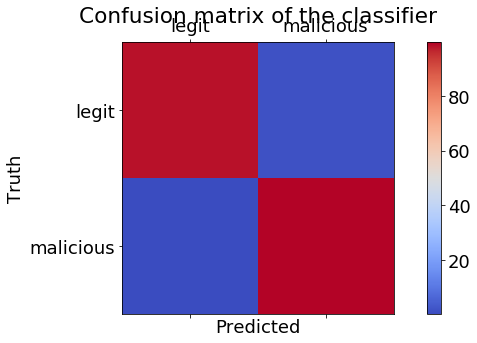

In [31]:
cm = confusion_matrix(y_test_lib, y_pred_lib, labels)
plot_cm(cm,labels,'injection',['length', 'entropy','lib_legit_g','lib_malicious_g'])

Confusion Matrix Stats
legit/legit: 99.19% (368/371)
legit/malicious: 0.81% (3/371)
malicious/legit: 0.96% (25/2602)
malicious/malicious: 99.04% (2577/2602)


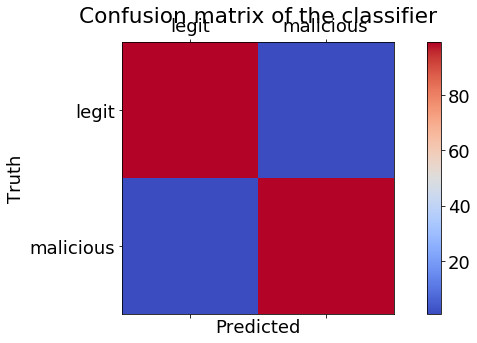

In [32]:
# Compute the precition probabilities and use them to mimimize our false positives
# Note: This is simply a trade off, it means we'll miss a few of the malicious
# ones but typically false alarms are a death blow to any new 'fancy stuff' so
# we definitely want to mimimize the false alarms.
y_probs = clf.predict_proba(X_test)[:,1]
thres = .95 # This can be set to whatever you'd like
y_pred[y_probs<thres] = 'legit'
y_pred[y_probs>=thres] = 'malicious'
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels,'sqlparse_prob',['length', 'entropy','legit_g','malicious_g'])

Confusion Matrix Stats
legit/legit: 99.72% (353/354)
legit/malicious: 0.28% (1/354)
malicious/legit: 0.88% (23/2619)
malicious/malicious: 99.12% (2596/2619)


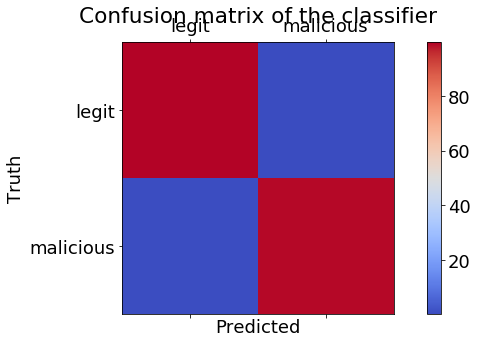

In [33]:
# Compute the precition probabilities and use them to mimimize our false positives
# Note: This is simply a trade off, it means we'll miss a few of the malicious
# ones but typically false alarms are a death blow to any new 'fancy stuff' so
# we definitely want to mimimize the false alarms.
y_probs_lib = clf_lib.predict_proba(X_test_lib)[:,1]
thres = .95 # This can be set to whatever you'd like
y_pred_lib[y_probs_lib<thres] = 'legit'
y_pred_lib[y_probs_lib>=thres] = 'malicious'
cm_lib = confusion_matrix(y_test_lib, y_pred_lib, labels)
plot_cm(cm_lib, labels,'injection_prob',['length', 'entropy','lib_legit_g','lib_malicious_g'])

In [34]:
# We can also look at what features the learning algorithm thought were the most important
importances = zip(['length', 'entropy', 'legit_g', 'malicious_g'], clf.feature_importances_)
list(importances)

[('length', 0.019456179663895918),
 ('entropy', 0.06432816080204672),
 ('legit_g', 0.5218249931340698),
 ('malicious_g', 0.3943906663999874)]

In [35]:
lib_importances = zip(['length', 'entropy', 'lib_legit_g', 'lib_malicious_g'], clf_lib.feature_importances_)
list(lib_importances)

[('length', 0.03016961703081291),
 ('entropy', 0.09610533029728666),
 ('lib_legit_g', 0.4672877435826767),
 ('lib_malicious_g', 0.40643730908922365)]

In [36]:
test_set = dataframe.loc[index_test]
test_set['pred'] = y_pred
misclassified = test_set[(test_set['type']=='legit') & (test_set['pred']=='malicious')]
misclassified.head()

,raw_sql,type,parsed_sql,lib_parsed_sql,sequences,lib_sequences,length,entropy,malicious_g,legit_g,malicious_g_lib,legit_g_lib,pred
13281,GoogleGitSign in eclipse / datatools/org.eclip...,legit,"[Identifier, Keyword, Operation, Operator, Ope...",nnnoo,"[('Identifier',), ('Keyword',), ('Operation',)...","[('n',), ('n',), ('n',), ('o',), ('o',), ('n',...",23,5.057291,-77.184682,698.534569,-444.307027,3490.812698,malicious
7639,"select E.eID, E.eLast, E.eFirst, E.eTitle from...",legit,"[DML, IdentifierList, Keyword, Identifier, Where]",Enknn,"[('DML',), ('IdentifierList',), ('Keyword',), ...","[('E',), ('n',), ('k',), ('n',), ('n',), ('E',...",5,4.236047,-504.004246,1731.427820,-448.163344,4759.339504,malicious
5461,"SELECT POUNDS, MOUTHS FROM HIPPO WHERE MOUTHS ...",legit,"[DML, IdentifierList, Keyword, Identifier, Where]",Enknk,"[('DML',), ('IdentifierList',), ('Keyword',), ...","[('E',), ('n',), ('k',), ('n',), ('k',), ('E',...",5,4.185239,-504.004246,1731.427820,-386.598231,4478.363295,malicious


In [37]:
test_set_lib = dataframe.loc[index_test_lib]
test_set_lib['pred'] = y_pred_lib
misclassified_lib = test_set_lib[(test_set_lib['type']=='legit') & (test_set_lib['pred']=='malicious')]
misclassified_lib.head()

,raw_sql,type,parsed_sql,lib_parsed_sql,sequences,lib_sequences,length,entropy,malicious_g,legit_g,malicious_g_lib,legit_g_lib,pred
12990,DECLARE @SNO char(6),legit,"[Keyword, Identifier, Function]",Tvf(1,"[('Keyword',), ('Identifier',), ('Function',),...","[('T',), ('v',), ('f',), ('(',), ('1',), ('T',...",3,4.121928,-492.982689,1883.027382,108.765785,184.125838,malicious


In [38]:
# 测试函数
# test_it shows how to do evaluation, also fun for manual testing below :)
def test_it(sql):
    parsed_sql = parse_it(sql)
    ngram_list = ngrams(parsed_sql, 3)
    malicious_g = g_aggregate(ngram_list, 'malicious_g',df_stats)
    legit_g = g_aggregate(ngram_list, 'legit_g',df_stats)
    _X = [len(parsed_sql), entropy(sql), legit_g, malicious_g]
    #print(np.asarray(_X).reshape(1, -1))
    print(' %s' % (clf.predict(np.asarray(_X).reshape(1, -1))[0]))
    return clf.predict(np.asarray(_X).reshape(1, -1))[0]

In [39]:
def test_it_lib(sql):
    parsed_sql = parse_it(sql)
    ngram_list = ngrams(parsed_sql, 3)
    malicious_g = g_aggregate(ngram_list, 'lib_malicious_g',df_stats_lib)
    legit_g = g_aggregate(ngram_list, 'lib_legit_g',df_stats_lib)
    _X = [len(parsed_sql), entropy(sql), legit_g, malicious_g]
#     print('%s' % (clf_lib.predict(np.asarray(_X).reshape(1, -1))[0]))
    return clf_lib.predict(np.asarray(_X).reshape(1, -1))[0]

In [40]:
count = 0
cnt = 0
with open('test.txt') as cheatsheets:
        for case in cheatsheets:
            count = count + 1
            x = test_it(case.strip('\n'))
            if x == 'malicious':
                cnt = cnt +1

 malicious
 legit
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 legit
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malicious
 malici

In [41]:
cnt/count

0.9844961240310077

In [42]:
count = 0
cnt = 0
with open('test.txt') as cheatsheets:
        for case in cheatsheets:
            count = count + 1
            x = test_it_lib(case.strip('\n'))
            if x == 'malicious':
                cnt = cnt +1


In [43]:
cnt/count

1.0

In [44]:
count = 0
cnt = 0
with open('test_1.txt') as cheatsheets:
        for case in cheatsheets:
            count = count + 1
            x = test_it(case.strip('\n'))
            if x == 'legit':
                cnt = cnt +1

 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit

 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit
 legit

In [45]:
cnt/count

0.994502977553825

In [46]:
count = 0
cnt = 0
with open('test_1.txt') as cheatsheets:
        for case in cheatsheets:
            count = count + 1
            x = test_it_lib(case.strip('\n'))
            if x == 'legit':
                cnt = cnt +1

In [47]:
cnt/count

0.011452130096197893

In [48]:
def test(sql,lst):
    parsed_sql = parse_it(sql)
    ngram_list = ngrams(parsed_sql, 3)
    malicious_g = g_aggregate(ngram_list, 'malicious_g',df_stats_lib)
    legit_g = g_aggregate(ngram_list, 'legit_g',df_stats_lib)
    dic = dict()
    dic['length'] = len(parsed_sql)
    dic['entropy'] = entropy(sql)
    dic['legit_g'] = legit_g
    dic['malicious_g'] = malicious_g
    _X = []
    for i in range(len(lst)):
        _X.append(dic[lst[i]])
#     _X = [len(parsed_sql), entropy(sql), legit_g, malicious_g]
# #     _X = [len(parsed_sql), legit_g, malicious_g]
#     #print(np.asarray(_X).reshape(1, -1))
# #     print('%s' % (clf_lib.predict(np.asarray(_X).reshape(1, -1))[0]))
    return clf_lib.predict(np.asarray(_X).reshape(1, -1))[0]

In [49]:
def tmp(lst):
    X_lib = dataframe.as_matrix(lst)
    X_train_lib, X_test_lib, y_train_lib, y_test_lib, index_train_lib, index_test_lib = train_test_split(X_lib, y_lib, dataframe.index, test_size=0.2)
    clf_lib.fit(X_train_lib, y_train_lib)
    y_pred_lib = clf_lib.predict(X_test_lib)
    cm = confusion_matrix(y_test_lib, y_pred_lib, labels)
    plot_cm(cm,labels,'injection',lst)
    y_probs_lib = clf_lib.predict_proba(X_test_lib)[:,1]
    thres = .95 # This can be set to whatever you'd like
    y_pred_lib[y_probs_lib<thres] = 'legit'
    y_pred_lib[y_probs_lib>=thres] = 'malicious'
    cm = confusion_matrix(y_test_lib, y_pred_lib, labels)
    plot_cm(cm, labels,'injection_prob',lst)

Confusion Matrix Stats
legit/legit: 2.81% (11/391)
legit/malicious: 97.19% (380/391)
malicious/legit: 0.46% (12/2582)
malicious/malicious: 99.54% (2570/2582)


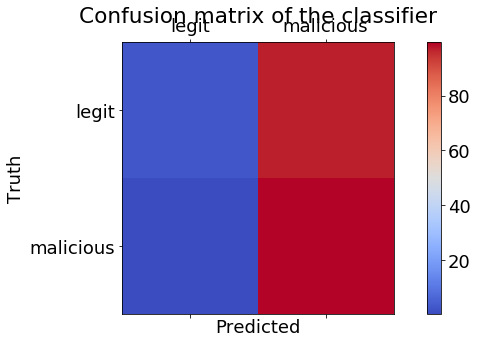

Confusion Matrix Stats
legit/legit: 91.82% (359/391)
legit/malicious: 8.18% (32/391)
malicious/legit: 69.75% (1801/2582)
malicious/malicious: 30.25% (781/2582)


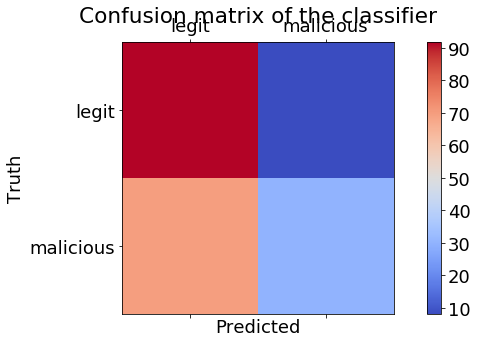

['length']
0.027943197434722858
Confusion Matrix Stats
legit/legit: 72.97% (270/370)
legit/malicious: 27.03% (100/370)
malicious/legit: 1.58% (41/2603)
malicious/malicious: 98.42% (2562/2603)


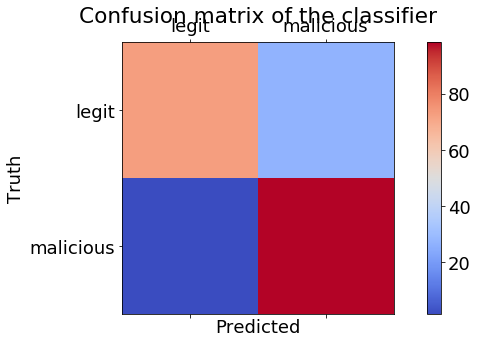

Confusion Matrix Stats
legit/legit: 85.14% (315/370)
legit/malicious: 14.86% (55/370)
malicious/legit: 7.38% (192/2603)
malicious/malicious: 92.62% (2411/2603)


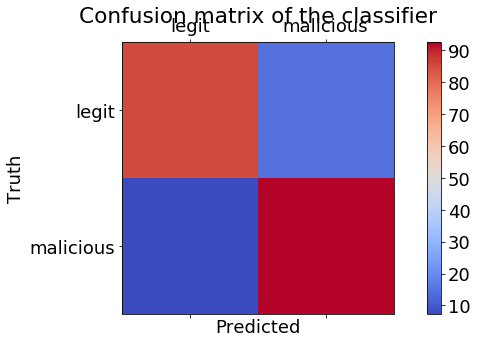

['length', 'entropy']
0.8946404031149794
Confusion Matrix Stats
legit/legit: 96.96% (351/362)
legit/malicious: 3.04% (11/362)
malicious/legit: 0.04% (1/2611)
malicious/malicious: 99.96% (2610/2611)


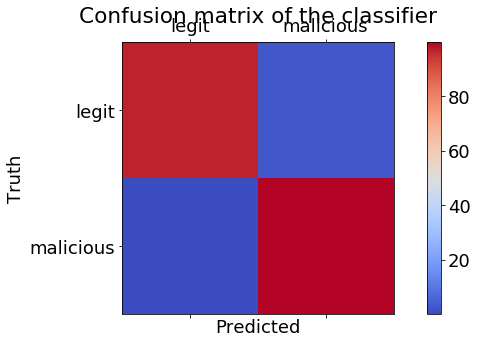

Confusion Matrix Stats
legit/legit: 99.72% (361/362)
legit/malicious: 0.28% (1/362)
malicious/legit: 0.54% (14/2611)
malicious/malicious: 99.46% (2597/2611)


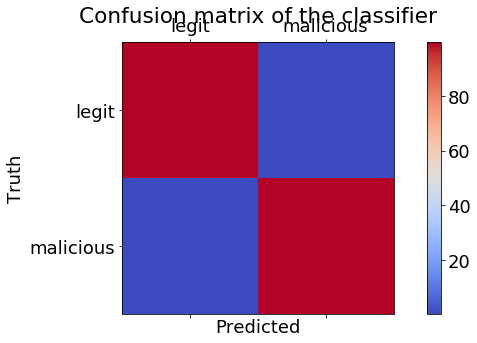

['length', 'entropy', 'legit_g']
0.00961978928080623
Confusion Matrix Stats
legit/legit: 98.87% (349/353)
legit/malicious: 1.13% (4/353)
malicious/legit: 0.08% (2/2620)
malicious/malicious: 99.92% (2618/2620)


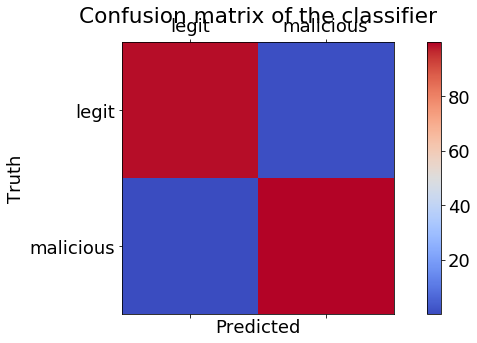

Confusion Matrix Stats
legit/legit: 99.43% (351/353)
legit/malicious: 0.57% (2/353)
malicious/legit: 0.53% (14/2620)
malicious/malicious: 99.47% (2606/2620)


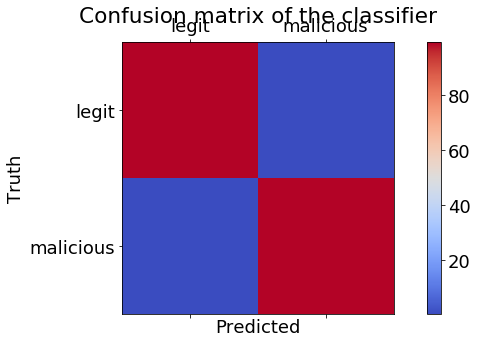

['length', 'entropy', 'legit_g', 'malicious_g']
0.0
Confusion Matrix Stats
legit/legit: 66.30% (244/368)
legit/malicious: 33.70% (124/368)
malicious/legit: 2.26% (59/2605)
malicious/malicious: 97.74% (2546/2605)


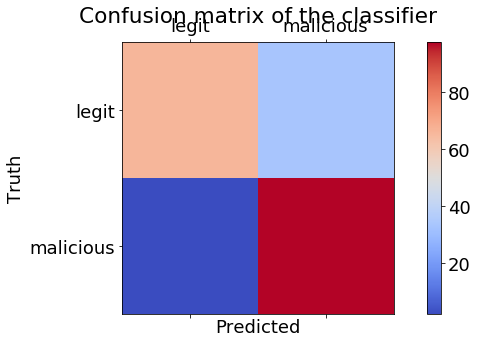

Confusion Matrix Stats
legit/legit: 77.45% (285/368)
legit/malicious: 22.55% (83/368)
malicious/legit: 10.98% (286/2605)
malicious/malicious: 89.02% (2319/2605)


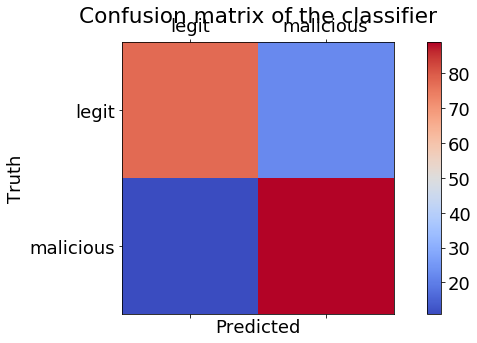

['entropy']
0.8712780577187357
Confusion Matrix Stats
legit/legit: 97.46% (384/394)
legit/malicious: 2.54% (10/394)
malicious/legit: 0.16% (4/2579)
malicious/malicious: 99.84% (2575/2579)


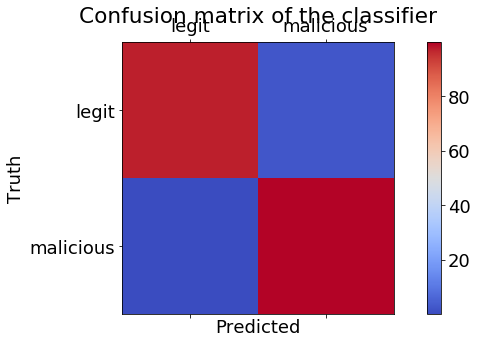

Confusion Matrix Stats
legit/legit: 98.98% (390/394)
legit/malicious: 1.02% (4/394)
malicious/legit: 0.78% (20/2579)
malicious/malicious: 99.22% (2559/2579)


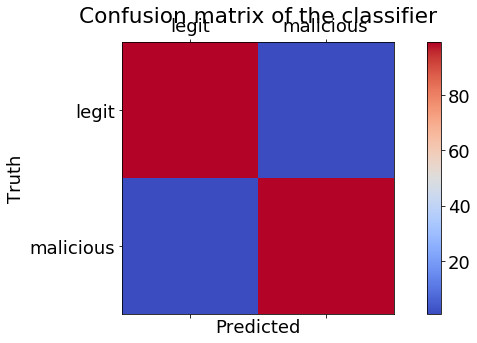

['entropy', 'legit_g']
0.005955107650022904
Confusion Matrix Stats
legit/legit: 97.75% (391/400)
legit/malicious: 2.25% (9/400)
malicious/legit: 0.19% (5/2573)
malicious/malicious: 99.81% (2568/2573)


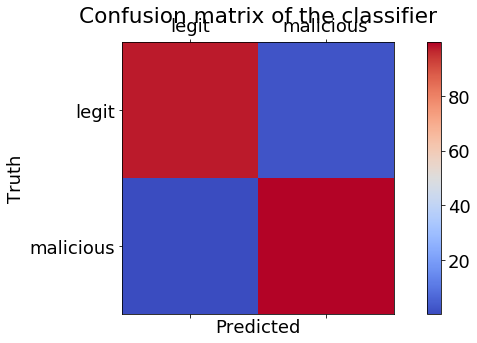

Confusion Matrix Stats
legit/legit: 99.75% (399/400)
legit/malicious: 0.25% (1/400)
malicious/legit: 1.13% (29/2573)
malicious/malicious: 98.87% (2544/2573)


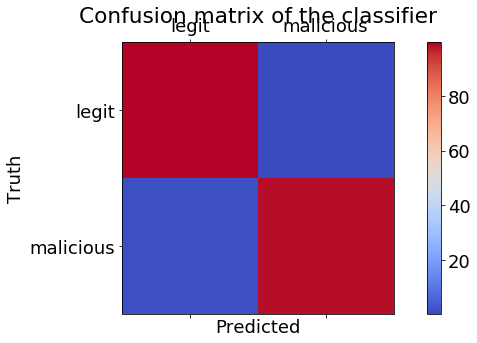

['entropy', 'legit_g', 'malicious_g']
0.0
Confusion Matrix Stats
legit/legit: 96.72% (383/396)
legit/malicious: 3.28% (13/396)
malicious/legit: 0.27% (7/2577)
malicious/malicious: 99.73% (2570/2577)


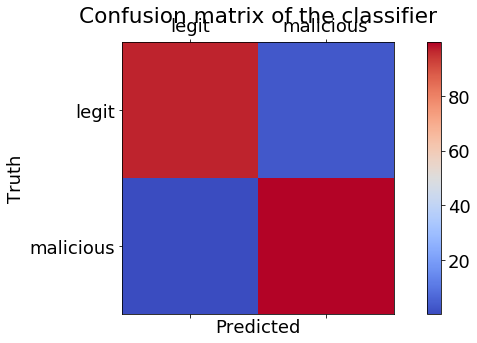

Confusion Matrix Stats
legit/legit: 98.99% (392/396)
legit/malicious: 1.01% (4/396)
malicious/legit: 1.20% (31/2577)
malicious/malicious: 98.80% (2546/2577)


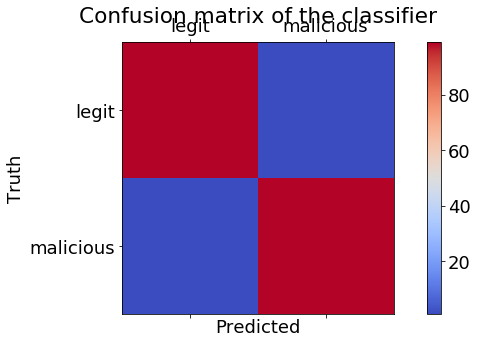

['legit_g']
0.0
Confusion Matrix Stats
legit/legit: 96.84% (337/348)
legit/malicious: 3.16% (11/348)
malicious/legit: 0.19% (5/2625)
malicious/malicious: 99.81% (2620/2625)


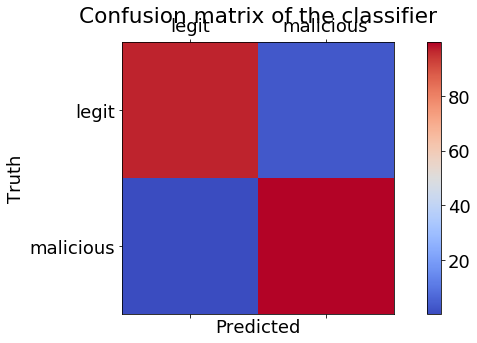

Confusion Matrix Stats
legit/legit: 99.43% (346/348)
legit/malicious: 0.57% (2/348)
malicious/legit: 0.95% (25/2625)
malicious/malicious: 99.05% (2600/2625)


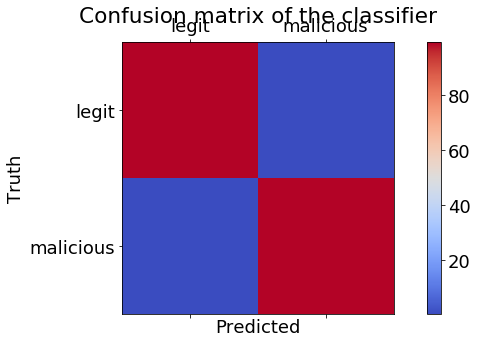

['legit_g', 'malicious_g']
0.0
Confusion Matrix Stats
legit/legit: 96.42% (350/363)
legit/malicious: 3.58% (13/363)
malicious/legit: 0.23% (6/2610)
malicious/malicious: 99.77% (2604/2610)


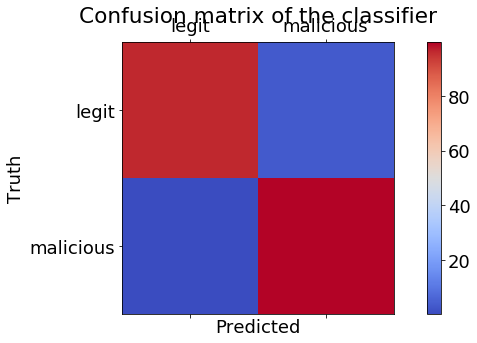

Confusion Matrix Stats
legit/legit: 98.35% (357/363)
legit/malicious: 1.65% (6/363)
malicious/legit: 0.80% (21/2610)
malicious/malicious: 99.20% (2589/2610)


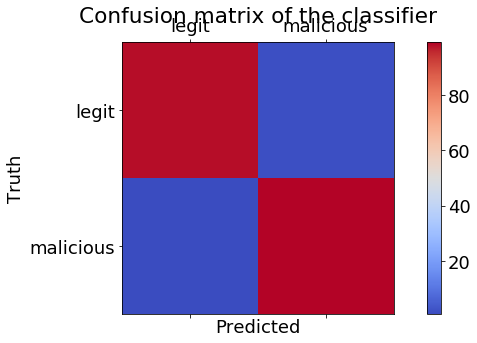

['malicious_g']
0.0


In [51]:
# libinjection 交叉验证
ret = dict()
lst = []
list_feature = ['length', 'entropy','legit_g','malicious_g']
y_lib = np.array(dataframe['type'].tolist())
clf_lib = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
for i in range(len(list_feature)):
    lst.clear()
    lst.append(list_feature[i])
    tmp(lst)
    count = 0
    cnt = 0
    with open('test_1.txt') as cheatsheets:
            for case in cheatsheets:
                count = count + 1
                x = test(case.strip('\n'),lst)
                if x == 'legit':
                    cnt = cnt +1
    print(lst)
    print(cnt/count)
    
    for j in range(i+1,len(list_feature)):
        lst.append(list_feature[j])
        tmp(lst)
        count = 0
        cnt = 0
        with open('test_1.txt') as cheatsheets:
            for case in cheatsheets:
                count = count + 1
                x = test(case.strip('\n'),lst)
                if x == 'legit':
                    cnt = cnt +1
        print(lst)
        print(cnt/count)
        
        